# CNN-GRU (30 frames)

```zsh
pipenv --python 3.11
pipenv install ipykernel==6.28.0 python-dotenv==1.0.0 torch torchvision torchinfo
```

## Imports

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torchinfo import summary
import os
import numpy as np
import json
import glob
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
from datetime import datetime
import torch.onnx
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
import re

## Load Dataset

In [2]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### My data

In [4]:
# Get a list of all txt files in ./data-gen/data/ and its subdirectories
txt_files = glob.glob('../../Jesus-data/downloads/', recursive=True)

for txt_file in txt_files:
    # Open the txt file and load the data
    with open(txt_file, 'r') as f:
        data = json.load(f)
    
    # Transform the data
    transformed_data = []
    for array in data:
        transformed_array = []
        for obj in array:
            transformed_array.append([obj['x'], obj['y'], obj['z']])
        transformed_data.append(transformed_array)
    
    # print(txt_file)
    # print(np.array(transformed_data).shape)

    # Create the new json file path
    json_file = os.path.splitext(txt_file)[0] + '.json'

    # Write the transformed data to the new json file
    with open(json_file, 'w') as f:
        json.dump(transformed_data, f)

IsADirectoryError: [Errno 21] Is a directory: '../../Jesus-data/downloads/'

In [5]:
# Assuming 'data' is your root directory containing all the data folders
root_dir = '../../data-gen/data/'
total_samples = 0

# Iterate over all folders in the root directory
for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)
    
    # Check if the path is indeed a folder
    if os.path.isdir(folder_path):
        # Count the number of json files in the folder
        num_files = len(glob.glob(os.path.join(folder_path, '*.json')))
        total_samples += num_files

print(f"Total number of samples: {total_samples}")

Total number of samples: 1540


(30, 21, 3) ==> (630, 3) ==> (3, 630)

In [7]:
batch_size=64

class LandmarkDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.encoder = LabelEncoder()
        self.labels = self.encoder.fit_transform(labels)

    def get_original_labels(self, encoded_labels):
        return self.encoder.inverse_transform(encoded_labels)
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        with open(self.files[idx], 'r') as f:
            data_list = json.load(f)
            filtered_data_list = [frame for i, frame in enumerate(data_list) if i % 2 == 0]  # Keep every other frame
            if any(len(frame) != 21 for frame in filtered_data_list):  # Check if each remaining frame has 21 landmarks
                print(f"Unexpected frame length in file {self.files[idx]} after filtering frames")
            data = torch.tensor(filtered_data_list)
            data = data.view(-1, 3)  # Flatten the data into (630, 3) because (30*21=630)
            data = data.transpose(0, 1)  # Transpose to get (3, 630)
        label = torch.tensor(self.labels[idx])
        return data, label

# Get a list of all json files in ../data-gen/data/ and its subdirectories
json_files = glob.glob('../../data-gen/data/**/*.json', recursive=True)

# Get labels (parent folder names) for each json file
labels = [os.path.basename(os.path.dirname(file)) for file in json_files]

# Split data into train and test sets
train_files, val_files, train_labels, val_labels = train_test_split(json_files, labels, test_size=0.2, random_state=42)

# Create train and test datasets
train_dataset = LandmarkDataset(train_files, train_labels)
val_dataset = LandmarkDataset(val_files, val_labels)

# Create train and test loaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

In [8]:
# get one batch of data
count = 0
for data, labels in train_loader:
    print(data.shape)
    print(labels.shape)
    count += 1
    print(count)


torch.Size([64, 3, 630])
torch.Size([64])
1
torch.Size([64, 3, 630])
torch.Size([64])
2
torch.Size([64, 3, 630])
torch.Size([64])
3
torch.Size([64, 3, 630])
torch.Size([64])
4
torch.Size([24, 3, 630])
torch.Size([24])
5


In [9]:
for data, labels in train_loader:
  print(data[0][0].shape)
  print(labels[0].item())
  # Get original labels
  original_labels = train_dataset.encoder.inverse_transform(labels)
  print(original_labels)

torch.Size([630])
0
['c' 'n' 'c' 'c' 'm' 'z' 'j' 'm' 'c' 'n' 'n' 'j' 'c' 'm' 'g' 'n' 'g' 'c'
 'g' 'c' 'c' 'm' 'g' 'm' 'i' 'n' 'g' 'g' 'c' 'c' 'z' 'j' 'g' 'm' 'n' 'j'
 'c' 'c' 'n' 'c' 'g' 'c' 'm' 'z' 'm' 'n' 'm' 'j' 'n' 'z' 'j' 'i' 'i' 'g'
 'm' 'i' 'g' 'n' 'g' 'j' 'i' 'n' 'n' 'n']
torch.Size([630])
0
['c' 'n' 'g' 'n' 'g' 'g' 'm' 'm' 'j' 'c' 'n' 'g' 'z' 'n' 'i' 'i' 'm' 'm'
 'z' 'n' 'g' 'j' 'n' 'n' 'c' 'g' 'i' 'c' 'z' 'i' 'c' 'i' 'z' 'i' 'j' 'i'
 'm' 'm' 'c' 'j' 'm' 'm' 'i' 'c' 'i' 'n' 'm' 'n' 'c' 'z' 'm' 'j' 'g' 'i'
 'g' 'g' 'z' 'j' 'j' 'z' 'm' 'i' 'i' 'm']
torch.Size([630])
0
['c' 'z' 'z' 'm' 'n' 'i' 'i' 'j' 'g' 'n' 'j' 'n' 'z' 'j' 'g' 'z' 'z' 'c'
 'm' 'n' 'z' 'j' 'm' 'j' 'm' 'g' 'i' 'j' 'i' 'z' 'i' 'c' 'j' 'n' 'i' 'n'
 'n' 'z' 'c' 'g' 'g' 'c' 'z' 'c' 'j' 'i' 'i' 'j' 'i' 'z' 'g' 'z' 'z' 'z'
 'j' 'g' 'z' 'n' 'j' 'z' 'g' 'c' 'i' 'c']
torch.Size([630])
6
['z' 'i' 'i' 'c' 'n' 'm' 'g' 'z' 'm' 'i' 'm' 'j' 'i' 'm' 'i' 'c' 'n' 'i'
 'z' 'z' 'm' 'c' 'g' 'j' 'm' 'z' 'i' 'z' 'n' 'j' 'g' 'c' 'i' 'c'

### Jesus's data

In [36]:
import os
import torch
from torch.utils.data import Dataset, DataLoader

def numerical_sort(value):
    numbers = re.findall(r'\d+', value)
    return int(numbers[0]) if numbers else float('inf')

class HandLandmarkDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.data = []
        self.labels = []
        self._load_data()

    def _load_data(self):
        # Iterate over each label directory in the root directory
        for label in os.listdir(self.root_dir): # A, B, C, etc--------------------------------------------
            label_dir = os.path.join(self.root_dir, label)  # Construct the full path to the label directory
            if os.path.isdir(label_dir):  # Check if the path is a directory
                capture_count = 0  # Initialize a counter for the number of captures
                # Iterate over each capture directory in the label directory
                for capture in os.listdir(label_dir): # capture_1, capture_2, etc (not sorted) --------------------------------
                    capture_dir = os.path.join(label_dir, capture)  # Construct the full path to the capture directory
                    if os.path.isdir(capture_dir):  # Check if the path is a directory
                        frames = []  # Initialize an empty list to store frames === capture
                        # Iterate over each frame file in the capture directory
                        if label == 'Z':
                            print(sorted(os.listdir(capture_dir)))
                            print(sorted(os.listdir(capture_dir), key=numerical_sort))
                        for frame_file in sorted(os.listdir(capture_dir), key=numerical_sort): # frame_1.txt, frame_2.txt, etc (numerically sorted) --------------
                            if frame_file.endswith('.txt'):  # Check if the file has a .txt extension
                                frame_path = os.path.join(capture_dir, frame_file)  # Construct the full path to the frame file
                                # Open the frame file and read its contents
                                with open(frame_path, 'r') as f:
                                    landmarks = []  # Initialize an empty list for landmarks
                                    for line in f:
                                        # Convert each line into an array of floats and append to the landmarks list
                                        landmarks.append([float(coord) for coord in line.strip().split()])
                                    frames.append(landmarks)  # Append the landmarks to the frames list
                        # Check if the number of frames in a capture is exactly 30
                        if len(frames) == 30:
                            self.data.append(frames)  # Append the frames list to the data list
                            self.labels.append(label)  # Append the label to the labels list
                            capture_count += 1  # Increment the capture counter
                        else:
                            print(f"Unexpected number of frames in {capture_dir}")
                print(f"{label}, {capture_count} captures: {np.array(self.data).shape}")  # Print the number of captures for the current label




    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        captures = self.data[idx]
        label = self.labels[idx]
        # (30, 21, 3) ==> (630, 3) ==> (3, 630)
        frames_tensor = torch.tensor(captures).view(-1, 3).transpose(0, 1)
        return frames_tensor, label

def collate_fn(batch):
    data = torch.stack([item[0] for item in batch])
    labels = [item[1] for item in batch]
    return data, labels

# Usage
root_dir = '../../Jesus-data/downloads/'
dataset = HandLandmarkDataset(root_dir)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Example of iterating through the data loader
for batch_data, batch_labels in data_loader:
    print(batch_data.shape)  # Should be (batch_size, 3, 630)
    print(batch_labels)
    break


J, 50 captures: (50, 30, 21, 3)
P, 30 captures: (80, 30, 21, 3)
G, 50 captures: (130, 30, 21, 3)
V, 30 captures: (160, 30, 21, 3)
L, 30 captures: (190, 30, 21, 3)
B, 30 captures: (220, 30, 21, 3)
D, 30 captures: (250, 30, 21, 3)
A, 30 captures: (280, 30, 21, 3)
Q, 30 captures: (310, 30, 21, 3)
O, 30 captures: (340, 30, 21, 3)
U, 30 captures: (370, 30, 21, 3)
I, 30 captures: (400, 30, 21, 3)
T, 30 captures: (430, 30, 21, 3)
C, 50 captures: (480, 30, 21, 3)
K, 30 captures: (510, 30, 21, 3)
R, 30 captures: (540, 30, 21, 3)
M, 50 captures: (590, 30, 21, 3)
F, 30 captures: (620, 30, 21, 3)
Y, 30 captures: (650, 30, 21, 3)
W, 30 captures: (680, 30, 21, 3)
E, 30 captures: (710, 30, 21, 3)
X, 30 captures: (740, 30, 21, 3)
N, 50 captures: (790, 30, 21, 3)
H, 30 captures: (820, 30, 21, 3)
S, 30 captures: (850, 30, 21, 3)
['frame_0.txt', 'frame_1.txt', 'frame_10.txt', 'frame_11.txt', 'frame_12.txt', 'frame_13.txt', 'frame_14.txt', 'frame_15.txt', 'frame_16.txt', 'frame_17.txt', 'frame_18.txt', 'f

### combined data

In [37]:
class CombinedDataset(Dataset):
    def __init__(self, landmark_files, landmark_labels, handlandmark_root_dir):
        self.landmark_files = landmark_files
        self.landmark_labels = [label.upper() for label in landmark_labels]
        self.handlandmark_root_dir = handlandmark_root_dir
        self.landmark_dataset = LandmarkDataset(self.landmark_files, self.landmark_labels)
        self.handlandmark_dataset = HandLandmarkDataset(self.handlandmark_root_dir)

        self.data = []
        self.labels = []
        self.encoder = LabelEncoder()
        self._combine_datasets()

    def _combine_datasets(self):
        # Combine data from LandmarkDataset
        for idx in range(len(self.landmark_dataset)):
            data, label = self.landmark_dataset[idx]
            self.data.append(data)
            self.labels.append(label)

        # Combine data from HandLandmarkDataset
        for idx in range(len(self.handlandmark_dataset)):
            data, label = self.handlandmark_dataset[idx]
            self.data.append(data)
            self.labels.append(label)

        # Fit the LabelEncoder on the combined labels and transform the labels
        self.labels = self.encoder.fit_transform(self.labels)
        print(f"Combined data shape: {np.array(self.data).shape}")

    def get_original_labels(self, encoded_labels):
        return self.encoder.inverse_transform(encoded_labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class LandmarkDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.encoder = LabelEncoder()
        self.labels = self.encoder.fit_transform([label.upper() for label in labels])  # Convert labels to uppercase

    def get_original_labels(self, encoded_labels):
        return self.encoder.inverse_transform(encoded_labels)
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        with open(self.files[idx], 'r') as f:
            data_list = json.load(f)
            filtered_data_list = [frame for i, frame in enumerate(data_list) if i % 2 == 0]  # Keep every other frame
            if any(len(frame) != 21 for frame in filtered_data_list):  # Check if each remaining frame has 21 landmarks
                print(f"Unexpected frame length in file {self.files[idx]} after filtering frames")
            data = torch.tensor(filtered_data_list)
            data = data.view(-1, 3)  # Flatten the data into (630, 3) because (30*21=630)
            data = data.transpose(0, 1)  # Transpose to get (3, 630)
        label = torch.tensor(self.labels[idx])
        return data, label

class HandLandmarkDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.data = []
        self.labels = []
        self._load_data()

    def _load_data(self):
        for label in os.listdir(self.root_dir):
            label_dir = os.path.join(self.root_dir, label)
            if os.path.isdir(label_dir):
                capture_count = 0
                for capture in os.listdir(label_dir):
                    capture_dir = os.path.join(label_dir, capture)
                    if os.path.isdir(capture_dir):
                        frames = []
                        for frame_file in sorted(os.listdir(capture_dir), key=numerical_sort):
                            if frame_file.endswith('.txt'):
                                frame_path = os.path.join(capture_dir, frame_file)
                                with open(frame_path, 'r') as f:
                                    landmarks = []
                                    for line in f:
                                        landmarks.append([float(coord) for coord in line.strip().split()])
                                    frames.append(landmarks)
                        if len(frames) == 30:
                            self.data.append(frames)
                            self.labels.append(label.upper())  # Convert label to uppercase
                            capture_count += 1
                        else:
                            print(f"Unexpected number of frames in {capture_dir}")
                # print(f"{label}, {capture_count} captures: {np.array(self.data).shape}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        captures = self.data[idx]
        label = self.labels[idx]
        frames_tensor = torch.tensor(captures).view(-1, 3).transpose(0, 1)
        return frames_tensor, label

def collate_fn(batch):
    data = torch.stack([item[0] for item in batch])
    labels = [item[1] for item in batch]
    return data, labels

# Get a list of all json files in ../data-gen/data/ and its subdirectories
json_files = glob.glob('../../data-gen/data/**/*.json', recursive=True)

# Get labels (parent folder names) for each json file
labels = [os.path.basename(os.path.dirname(file)) for file in json_files]

# Root directory for HandLandmarkDataset
root_dir = '../../Jesus-data/downloads/'

# Create combined dataset
combined_dataset = CombinedDataset(json_files, labels, root_dir)

# Split combined data into train and val sets
train_data, val_data, train_labels, val_labels = train_test_split(combined_dataset.data, combined_dataset.labels, test_size=0.2, random_state=42)

# Create train and val datasets
train_dataset = torch.utils.data.TensorDataset(torch.stack(train_data), torch.tensor(train_labels))
val_dataset = torch.utils.data.TensorDataset(torch.stack(val_data), torch.tensor(val_labels))

# Create train and val loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Combined data shape: (1250, 3, 630)


### combined data (used ConcatDataset)

In [38]:
class LandmarkDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.encoder = LabelEncoder()
        self.labels = self.encoder.fit_transform([label.upper() for label in labels])  # Convert labels to uppercase

    def get_original_labels(self, encoded_labels):
        return self.encoder.inverse_transform(encoded_labels)
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        with open(self.files[idx], 'r') as f:
            data_list = json.load(f)
            filtered_data_list = [frame for i, frame in enumerate(data_list) if i % 2 == 0]  # Keep every other frame
            if any(len(frame) != 21 for frame in filtered_data_list):  # Check if each remaining frame has 21 landmarks
                print(f"Unexpected frame length in file {self.files[idx]} after filtering frames")
            data = torch.tensor(filtered_data_list)
            data = data.view(-1, 3)  # Flatten the data into (630, 3) because (30*21=630)
            data = data.transpose(0, 1)  # Transpose to get (3, 630)
        label = torch.tensor(self.labels[idx])
        return data, label

class HandLandmarkDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.data = []
        self.labels = []
        self._load_data()

        self.encoder = LabelEncoder()
        self.labels = self.encoder.fit_transform([label.upper() for label in self.labels])

    def _load_data(self):
        for label in os.listdir(self.root_dir):
            label_dir = os.path.join(self.root_dir, label)
            if os.path.isdir(label_dir):
                capture_count = 0
                for capture in os.listdir(label_dir):
                    capture_dir = os.path.join(label_dir, capture)
                    if os.path.isdir(capture_dir):
                        frames = []
                        for frame_file in sorted(os.listdir(capture_dir), key=numerical_sort):
                            if frame_file.endswith('.txt'):
                                frame_path = os.path.join(capture_dir, frame_file)
                                with open(frame_path, 'r') as f:
                                    landmarks = []
                                    for line in f:
                                        landmarks.append([float(coord) for coord in line.strip().split()])
                                    frames.append(landmarks)
                        if len(frames) == 30:
                            self.data.append(frames)
                            self.labels.append(label.upper())  # Convert label to uppercase
                            capture_count += 1
                        else:
                            print(f"Unexpected number of frames in {capture_dir}")
                # print(f"{label}, {capture_count} captures: {np.array(self.data).shape}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        captures = self.data[idx]
        label = self.labels[idx]
        frames_tensor = torch.tensor(captures).view(-1, 3).transpose(0, 1)
        return frames_tensor, label

def collate_fn(batch):
    data = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch])
    return data, labels

# Get a list of all json files in ../data-gen/data/ and its subdirectories
json_files = glob.glob('../../data-gen/data/**/*.json', recursive=True)

# Get labels (parent folder names) for each json file
labels = [os.path.basename(os.path.dirname(file)) for file in json_files]

# Create LandmarkDataset
landmark_dataset = LandmarkDataset(json_files, labels)

# Root directory for HandLandmarkDataset
root_dir = '../../Jesus-data/downloads/'

# Create HandLandmarkDataset
handlandmark_dataset = HandLandmarkDataset(root_dir)

# Combine datasets using ConcatDataset
combined_dataset = ConcatDataset([landmark_dataset, handlandmark_dataset])

# Split combined dataset into train and val sets
combined_size = len(combined_dataset)
indices = list(range(combined_size))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

batch_size = 64
train_loader = DataLoader(combined_dataset, batch_size=batch_size, sampler=train_sampler, collate_fn=collate_fn)
val_loader = DataLoader(combined_dataset, batch_size=batch_size, sampler=val_sampler, collate_fn=collate_fn)

print("Train and validation loaders created successfully.")


Train and validation loaders created successfully.


### randome X flip

In [94]:
import os
import re
import json
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.preprocessing import LabelEncoder

def numerical_sort(value):
    numbers = re.findall(r"\d+", value)
    return int(numbers[0]) if numbers else float("inf")

class LandmarkDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.encoder = LabelEncoder()
        self.labels = self.encoder.fit_transform(
            [label.upper() for label in labels]
        )  # Convert labels to uppercase

    def get_original_labels(self, encoded_labels):
        return self.encoder.inverse_transform(encoded_labels)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        with open(self.files[idx], "r") as f:
            data_list = json.load(f)
            filtered_data_list = [
                frame for i, frame in enumerate(data_list) if i % 2 == 0
            ]  # Keep every other frame
            
            for frame_idx, frame in enumerate(filtered_data_list):
                if len(frame) != 21:
                    raise ValueError(f"Unexpected frame length in file {self.files[idx]} at frame {frame_idx}")
            
            data = torch.tensor(filtered_data_list)
            data = data.view(
                -1, 3
            )  # Flatten the data into (630, 3) because (30*21=630)

            # Random x-coordinate flip
            if random.random() > 0.5:
                data[:, 0] = -data[:, 0]

            data = data.transpose(0, 1)  # Transpose to get (3, 630)
        label = torch.tensor(self.labels[idx])
        return data, label

class HandLandmarkDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.data = []
        self.labels = []
        self._load_data()

        self.encoder = LabelEncoder()
        self.labels = self.encoder.fit_transform(
            [label.upper() for label in self.labels]
        )

    def _load_data(self):
        for label in os.listdir(self.root_dir):
            label_dir = os.path.join(self.root_dir, label)
            if os.path.isdir(label_dir):
                capture_count = 0
                for capture in os.listdir(label_dir):
                    capture_dir = os.path.join(label_dir, capture)
                    if os.path.isdir(capture_dir):
                        frames = []
                        for frame_file in sorted(
                            os.listdir(capture_dir), key=numerical_sort
                        ):
                            if frame_file.endswith(".txt"):
                                frame_path = os.path.join(capture_dir, frame_file)
                                with open(frame_path, "r") as f:
                                    landmarks = []
                                    for line in f:
                                        landmarks.append(
                                            [
                                                float(coord)
                                                for coord in line.strip().split()
                                            ]
                                        )
                                    frames.append(landmarks)
                        if len(frames) == 30:
                            self.data.append(frames)
                            self.labels.append(
                                label.upper()
                            )  # Convert label to uppercase
                            capture_count += 1
                        else:
                            print(f"Unexpected number of frames in {capture_dir}")
                # print(f"{label}, {capture_count} captures: {np.array(self.data).shape}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        captures = self.data[idx]
        label = self.labels[idx]
        frames_tensor = torch.tensor(captures).view(-1, 3)

        # Random x-coordinate flip
        if random.random() > 0.5:
            frames_tensor[:, 0] = -frames_tensor[:, 0]

        frames_tensor = frames_tensor.transpose(0, 1)
        return frames_tensor, label

def collate_fn(batch):
    data = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch])
    return data, labels

def check_data_loader(data_loader):
    for batch_idx, (inputs, labels) in enumerate(data_loader):
        for i, data in enumerate(inputs):
            if data is None:
                print(f"Corrupted data found in batch {batch_idx}, item {i}")
            else:
                try:
                    _ = data.view(-1, 3)
                except Exception as e:
                    print(f"Corrupted data found in batch {batch_idx}, item {i}: {e}")

# Get a list of all json files in ../data-gen/data/ and its subdirectories
json_files = glob.glob("../../data-gen/data/**/*.json", recursive=True)

# Get labels (parent folder names) for each json file
labels = [os.path.basename(os.path.dirname(file)) for file in json_files]

# Create LandmarkDataset
landmark_dataset = LandmarkDataset(json_files, labels)

# Root directory for HandLandmarkDataset
root_dir = "../../Jesus-data/downloads/"

# Create HandLandmarkDataset
handlandmark_dataset = HandLandmarkDataset(root_dir)

# Combine datasets using ConcatDataset
combined_dataset = ConcatDataset([landmark_dataset, handlandmark_dataset])

# Create data loaders
batch_size = 64
data_loader = DataLoader(combined_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Check data loader for corrupted data
check_data_loader(data_loader)


In [78]:
import random
import os
import json
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


def numerical_sort(value):
    numbers = re.findall(r"\d+", value)
    return int(numbers[0]) if numbers else float("inf")


class LandmarkDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.encoder = LabelEncoder()
        self.labels = self.encoder.fit_transform(
            [label.upper() for label in labels]
        )  # Convert labels to uppercase

    def get_original_labels(self, encoded_labels):
        return self.encoder.inverse_transform(encoded_labels)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        with open(self.files[idx], "r") as f:
            data_list = json.load(f)
            filtered_data_list = [
                frame for i, frame in enumerate(data_list) if i % 2 == 0
            ]  # Keep every other frame
            if any(
                len(frame) != 21 for frame in filtered_data_list
            ):  # Check if each remaining frame has 21 landmarks
                print(
                    f"Unexpected frame length in file {self.files[idx]} after filtering frames"
                )
            data = torch.tensor(filtered_data_list)
            data = data.view(
                -1, 3
            )  # Flatten the data into (630, 3) because (30*21=630)

            # Random x-coordinate flip
            if random.random() > 0.5:
                data[:, 0] = -data[:, 0]

            data = data.transpose(0, 1)  # Transpose to get (3, 630)
        label = torch.tensor(self.labels[idx])
        return data, label


class HandLandmarkDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.data = []
        self.labels = []
        self._load_data()

        self.encoder = LabelEncoder()
        self.labels = self.encoder.fit_transform(
            [label.upper() for label in self.labels]
        )

    def _load_data(self):
        for label in os.listdir(self.root_dir):
            label_dir = os.path.join(self.root_dir, label)
            if os.path.isdir(label_dir):
                capture_count = 0
                for capture in os.listdir(label_dir):
                    capture_dir = os.path.join(label_dir, capture)
                    if os.path.isdir(capture_dir):
                        frames = []
                        for frame_file in sorted(
                            os.listdir(capture_dir), key=numerical_sort
                        ):
                            if frame_file.endswith(".txt"):
                                frame_path = os.path.join(capture_dir, frame_file)
                                with open(frame_path, "r") as f:
                                    landmarks = []
                                    for line in f:
                                        landmarks.append(
                                            [
                                                float(coord)
                                                for coord in line.strip().split()
                                            ]
                                        )
                                    frames.append(landmarks)
                        if len(frames) == 30:
                            self.data.append(frames)
                            self.labels.append(
                                label.upper()
                            )  # Convert label to uppercase
                            capture_count += 1
                        else:
                            print(f"Unexpected number of frames in {capture_dir}")
                # print(f"{label}, {capture_count} captures: {np.array(self.data).shape}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        captures = self.data[idx]
        label = self.labels[idx]
        frames_tensor = torch.tensor(captures).view(-1, 3)

        # Random x-coordinate flip
        if random.random() > 0.5:
            frames_tensor[:, 0] = -frames_tensor[:, 0]

        frames_tensor = frames_tensor.transpose(0, 1)
        return frames_tensor, label


def collate_fn(batch):
    data = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch])
    return data, labels


# Get a list of all json files in ../data-gen/data/ and its subdirectories
json_files = glob.glob("../../data-gen/data/**/*.json", recursive=True)

# Get labels (parent folder names) for each json file
labels = [os.path.basename(os.path.dirname(file)) for file in json_files]

# Create LandmarkDataset
landmark_dataset = LandmarkDataset(json_files, labels)

# Root directory for HandLandmarkDataset
root_dir = "../../Jesus-data/downloads/"

# Create HandLandmarkDataset
handlandmark_dataset = HandLandmarkDataset(root_dir)

# Combine datasets using ConcatDataset
combined_dataset = ConcatDataset([landmark_dataset, handlandmark_dataset])

# Split combined dataset into train and val sets
combined_size = len(combined_dataset)
indices = list(range(combined_size))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

batch_size = 64
train_loader = DataLoader(
    combined_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    collate_fn=collate_fn,
)
val_loader = DataLoader(
    combined_dataset, batch_size=batch_size, sampler=val_sampler, collate_fn=collate_fn
)

print("Train and validation loaders created successfully.")

Train and validation loaders created successfully.


In [79]:
# Check the size of the combined dataset
combined_size = len(combined_dataset)
print(f"Total number of samples in the combined dataset: {combined_size}")

# Example of iterating through the data loader
for batch_data, batch_labels in train_loader:
    print(batch_data.shape)  # Should be (batch_size, 3, 630)
    print(batch_labels)
    break


Total number of samples in the combined dataset: 3309
torch.Size([64, 3, 630])
tensor([ 3,  2, 12, 11, 11, 12,  2,  6, 11, 13, 12, 23, 17,  2, 14, 24, 15,  9,
        11,  6,  0, 17, 18, 24, 14, 18, 22, 21,  8, 25, 25, 22, 21,  7,  4, 16,
         0, 21, 25, 22, 18,  8, 14, 24, 11,  4, 13, 13, 20, 11,  3, 17,  3, 11,
         2, 23,  3, 13, 16, 16, 20, 20, 23, 12])


## Model Set Up

```txt
Model
├── Input Layer
│   └── Conv1D
│       └── MaxPooling1D
│           └── Flatten
│               └── Dense
│                   ├── Concatenate (Final Layer)
│                   └── Reshape
│                       └── GRU
│                           └── GRU_1
│                               └── Dense_1
│                                   └── Concatenate (Final Layer)
``` 
PyTorch's Conv1D layer expects input in the form (batch_size, num_channels, length). In your case, you can consider each coordinate as a channel. So, your input to the Conv1D layer would be (batch_size, 3, 1260), where 1260 is the product of 60 (frames) and 21 (landmarks).

(30, 21, 3) ==> (630, 3) ==> (3, 630) ==> (batch_size, 3, 630)

In PyTorch, it's common to leave out the softmax activation function in the model and instead use the nn.CrossEntropyLoss loss function during training, which applies the softmax function internally. Then, when making predictions, you can apply the softmax function to the model's outputs to get probabilities.

In [72]:
class CNN_GRU_Model(nn.Module):
    def __init__(self):
        super(CNN_GRU_Model, self).__init__()
        self.conv1d = nn.Conv1d(3, 64, kernel_size=3, padding=1)
        self.maxpooling1d = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        # Calculate the output size after Conv1d and MaxPool1d
        conv_output_size = 64 * (630 // 2)  # Output channels * reduced sequence length
        self.dense = nn.Linear(conv_output_size, 64)  # Adjust this based on the output of the previous layer
        self.gru = nn.GRU(64, 100, batch_first=True)
        self.gru_1 = nn.GRU(100, 100, batch_first=True)
        self.dense_1 = nn.Linear(100, 64)
        self.final_dense = nn.Linear(128, 26)  # Final Dense layer for 7 classes

    def forward(self, x):
        x = self.conv1d(x)
        x = self.maxpooling1d(x)
        x = self.flatten(x)
        dense_output = self.dense(x)
        x = dense_output.view(dense_output.shape[0], 1, -1)
        x, _ = self.gru(x)
        x, _ = self.gru_1(x)
        x = self.dense_1(x[:, -1, :])
        x = torch.cat((dense_output, x), dim=1)
        x = self.final_dense(x)
        return x

# Instantiate the model
model = CNN_GRU_Model().to(device)

# Print model summary
print(summary(model, input_size=(batch_size, 3, 630)))


Layer (type:depth-idx)                   Output Shape              Param #
CNN_GRU_Model                            [64, 26]                  --
├─Conv1d: 1-1                            [64, 64, 630]             640
├─MaxPool1d: 1-2                         [64, 64, 315]             --
├─Flatten: 1-3                           [64, 20160]               --
├─Linear: 1-4                            [64, 64]                  1,290,304
├─GRU: 1-5                               [64, 1, 100]              49,800
├─GRU: 1-6                               [64, 1, 100]              60,600
├─Linear: 1-7                            [64, 64]                  6,464
├─Linear: 1-8                            [64, 26]                  3,354
Total params: 1,411,162
Trainable params: 1,411,162
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 116.08
Input size (MB): 0.48
Forward/backward pass size (MB): 20.83
Params size (MB): 5.64
Estimated Total Size (MB): 26.95


## Training

In [10]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rik0. Use `wandb login --relogin` to force relogin


True

In [34]:
def calculate_accuracy(loader):
    correct = 0
    total = 0
    # Set model to evaluation mode
    model.eval()
    # Disable gradient calculation (unnecessary for inference)
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [87]:
now = datetime.now()  # current date and time
run_time = now.strftime("%Y-%m-%d_%H-%M-%S")
# run = wandb.init(project="sign_language", name=f"CNN-GRU_{run_time}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 4

train_accuracies = []
val_accuracies = []
losses = []

for epoch in range(num_epochs):
    # Set model to training mode
    model.train()

    # Iterate over data
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
        # Log loss to WandB
        wandb.log({"train_loss": loss.item()})

    train_accuracy = calculate_accuracy(train_loader)
    train_accuracies.append(train_accuracy)
    
    # Log train accuracy to WandB
    wandb.log({"train_accuracy": train_accuracy})

    # Evaluate on validation set
    val_accuracy = calculate_accuracy(val_loader)
    val_accuracies.append(val_accuracy)
    
    # Log validation accuracy to WandB
    wandb.log({"val_accuracy": val_accuracy})
    
    print(f"Epoch {epoch+1}/{num_epochs}, Validation accuracy: {val_accuracy}%")

# Optionally, log final metrics after training completes
wandb.log({"final_train_accuracy": train_accuracies[-1], "final_val_accuracy": val_accuracies[-1]})


Epoch 1/4, Validation accuracy: 97.43202416918429%
Epoch 2/4, Validation accuracy: 97.43202416918429%


KeyboardInterrupt: 

In [81]:
# total_train_accuracies = []
# total_val_accuracies = []
# total_losses = []

In [88]:
total_train_accuracies += train_accuracies
total_val_accuracies += val_accuracies
total_losses += losses

In [89]:
print(len(total_train_accuracies))
print(len(total_val_accuracies))
print(len(total_losses))
print(len(range(1, len(total_losses) + 1)))

48
48
2097
2097


## Evaluation

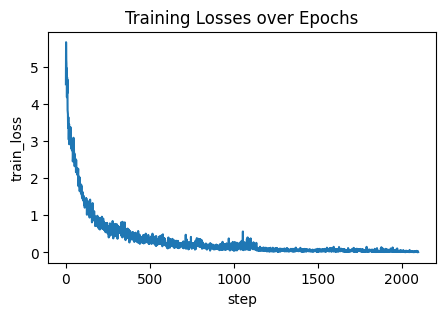

In [90]:
# Create a dataframe
df_loss = pd.DataFrame({
    'step': range(1, len(total_losses) + 1),
    'train_loss': total_losses,
})

# Create lineplot for losses
plt.figure(figsize=(5, 3))
sns.lineplot(data=df_loss, x='step', y='train_loss')
plt.title('Training Losses over Epochs')
plt.show()

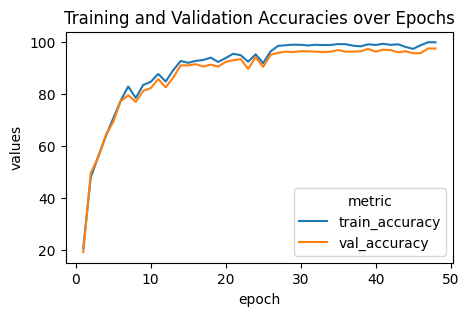

In [91]:
# Create a dataframe
df_acc = pd.DataFrame({
    'epoch': range(1, len(total_train_accuracies) + 1),
    'train_accuracy': total_train_accuracies,
    'val_accuracy': total_val_accuracies
})

# Melt dataframe to long-form for easier plotting
df_acc_melted = df_acc.melt('epoch', var_name='metric', value_name='values')

# Create lineplot for accuracies
plt.figure(figsize=(5, 3))
sns.lineplot(data=df_acc_melted, x='epoch', y='values', hue='metric')
plt.title('Training and Validation Accuracies over Epochs')
plt.show()

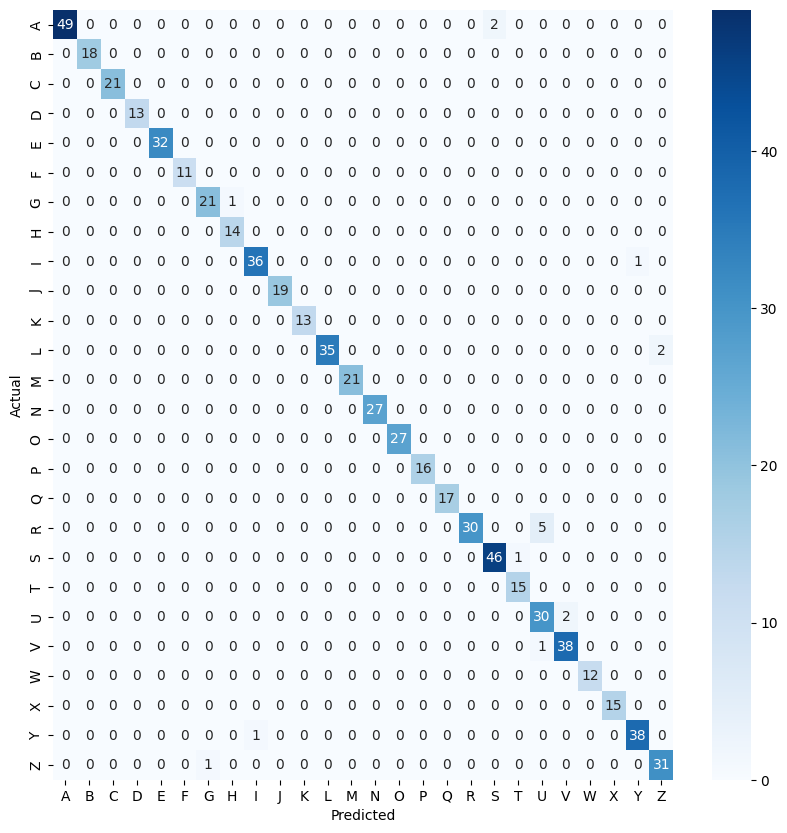

In [92]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Get actual labels
# actual_labels = train_dataset.get_original_labels(range(len(train_dataset.encoder.classes_)))
alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
actual_labels = [alphabets[i] for i in range(26)]

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actual_labels, yticklabels=actual_labels)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [93]:
# Collect validation features and labels
X_val = []
y_val = []

for data in val_loader:
    inputs, labels = data
    X_val.extend(inputs.numpy())  # Assuming inputs is a Tensor
    y_val.extend(labels.numpy())  # Assuming labels is a Tensor

X_val = torch.tensor(X_val).to(device)
y_val = torch.tensor(y_val).to(device)

# Use your model to predict and evaluate
model.eval()
with torch.no_grad():
    y_pred = model(X_val)
    y_pred = y_pred.argmax(dim=1)

# Move y_val and y_pred back to CPU for evaluation
y_val = y_val.cpu()
y_pred = y_pred.cpu()

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted') # 'weighted' accounts for label imbalance
f1 = f1_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")


Accuracy: 0.974320241691843
Precision: 0.9749656934548974
F1 Score: 0.974386374860828
Recall: 0.974320241691843


In [67]:
torch.save(model, 'model.pth')

In [68]:
wandb.save("model.pth")
run.finish()

final_train_accuracy,▁▄▃█
final_val_accuracy,▂▁▃█
train_accuracy,▁▃▅▆▇▆▇▇▇▇██▇▇████████▇█████████████████
train_loss,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▆▆▇▇▇▇▇█▇██████▇▇███████████████████
final_train_accuracy,100.0
final_val_accuracy,97.42765
train_accuracy,100.0
train_loss,0.00175
val_accuracy,97.42765


## Convert model to other format

In [93]:
# load model.pth
model = torch.load('model.pth')

### ONNX

In [69]:
# Create a dummy input with appropriate data type
dummy_input = torch.randn(64, 3, 630, device=device, dtype=torch.float32)

# Specify the file path where you want to save the ONNX model
onnx_file_path = "model.onnx"

# Export the model to ONNX format
torch.onnx.export(
    model,                     # model being run
    dummy_input,               # model input (or a tuple for multiple inputs)
    onnx_file_path,            # where to save the model (can be a file or file-like object)
    export_params=True,        # store the trained parameter weights inside the model file
    opset_version=10,          # the ONNX version to export the model to
    do_constant_folding=True,  # whether to execute constant folding for optimization
    input_names=['input'],     # the model's input names
    output_names=['output'],   # the model's output names
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # variable length axes
)


print(f"Model has been saved to {onnx_file_path}")


Model has been saved to model977.onnx


/home/ubuntu/.local/share/virtualenvs/CNN-GRU-9IlhNg0D/lib/python3.11/site-packages/torch/onnx/symbolic_opset9.py:4661: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [95]:
# import onnx
# from onnx import helper, numpy_helper
# import numpy as np

# # Load the ONNX model
# onnx_model = onnx.load(onnx_file_path)

# # Check and convert int64 tensors to int32
# def convert_int64_to_int32(model):
#     for initializer in model.graph.initializer:
#         if initializer.data_type == onnx.TensorProto.INT64:
#             int64_data = numpy_helper.to_array(initializer)
#             int32_data = int64_data.astype(np.int32)
#             new_initializer = numpy_helper.from_array(int32_data, initializer.name)
#             model.graph.initializer.remove(initializer)
#             model.graph.initializer.append(new_initializer)

#     for node in model.graph.node:
#         for attr in node.attribute:
#             if attr.type == onnx.AttributeProto.TENSOR and attr.t.data_type == onnx.TensorProto.INT64:
#                 int64_data = numpy_helper.to_array(attr.t)
#                 int32_data = int64_data.astype(np.int32)
#                 new_tensor = numpy_helper.from_array(int32_data)
#                 new_tensor.name = attr.t.name
#                 attr.t.CopyFrom(new_tensor)

#     return model

# # Convert and save the modified model
# onnx_model = convert_int64_to_int32(onnx_model)
# onnx.save(onnx_model, onnx_file_path)

# # Verify the ONNX model for int64 tensors
# def check_for_int64(model):
#     for tensor in model.graph.initializer:
#         if tensor.data_type == onnx.TensorProto.INT64:
#             print(f"Found int64 tensor in initializer {tensor.name}")
#             return True
#     for node in model.graph.node:
#         for attr in node.attribute:
#             if attr.type == onnx.AttributeProto.TENSOR and attr.t.data_type == onnx.TensorProto.INT64:
#                 print(f"Found int64 tensor in node {node.name}")
#                 return True
#     return False

# if check_for_int64(onnx_model):
#     print("Model contains int64 tensors. Modify the model to use int32 tensors.")
# else:
#     print("Model does not contain int64 tensors.")



### TorchScript

In [96]:
scripted_model = torch.jit.script(model)  # Convert to TorchScript
scripted_model.save('model_scripted.pt')  # Save the scripted model

In [97]:
from onnx_tf.backend import prepare
import onnx

onnx_model = onnx.load("model.onnx")
tf_rep = prepare(onnx_model)
tf_rep.export_graph("model_tf.pb")

ModuleNotFoundError: No module named 'tensorflow_probability'

In [ ]:
# bash command to convert the TensorFlow model to TensorFlow.js
# tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model model_tf web_model

tensorflow

pytorch -> onnx -> tensorflow -> tensorflow.js

uses @tensorflow/tfjs on the front

error when onnx -> tensorflow

onnx

pytorch -> onnx

ueses either onnxjs or onnxruntime-web

onnxjs: error when loading model

onnxruntime-web: error with wasm << solved!!

In [ ]:
# Save the model state_dict
torch.save(model.state_dict(), 'model_state_dict.pth')

In [ ]:
import torch
import json

# Define your model class exactly as it was when you saved the model
class CNN_GRU_Model(nn.Module):
    def __init__(self):
        super(CNN_GRU_Model, self).__init__()
        self.conv1d = nn.Conv1d(3, 64, kernel_size=3)
        self.maxpooling1d = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(40256, 64)  # Adjust this based on the output of the previous layer
        self.gru = nn.GRU(64, 100, batch_first=True)
        self.gru_1 = nn.GRU(100, 100, batch_first=True)
        self.dense_1 = nn.Linear(100, 64)
        self.final_dense = nn.Linear(128, 7)  # Final Dense layer for 7 classes

    def forward(self, x):
        x = self.conv1d(x)
        x = self.maxpooling1d(x)
        x = self.flatten(x)
        dense_output = self.dense(x)
        x = dense_output.view(dense_output.shape[0], 1, -1)
        x, _ = self.gru(x)
        x, _ = self.gru_1(x)
        x = self.dense_1(x[:, -1, :])
        x = torch.cat((dense_output, x), dim=1)
        x = self.final_dense(x)
        return x

# Load the model
model = CNN_GRU_Model()

# Load the state_dict
state_dict = torch.load('model_state_dict.pth')

# Ensure the state_dict is in the correct format (i.e., a dictionary)
if not isinstance(state_dict, dict):
    raise TypeError(f"Expected state_dict to be dict-like, got {type(state_dict)}.")

# Load the state_dict into the model
model.load_state_dict(state_dict)

# Extract the model's state_dict (parameters)
model_state_dict = model.state_dict()

# Convert the state_dict to a dictionary suitable for JSON
model_state_dict = {k: v.tolist() for k, v in model_state_dict.items()}

# Save the state_dict to a JSON file
with open('model.json', 'w') as json_file:
    json.dump(model_state_dict, json_file)

print("Model saved to model.json")



Model saved to model.json
